In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPool2D, BatchNormalization, AlphaDropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [3]:
def build_model(lr, lr_decay, n_conv, n_dense, dense_k, dropout):
    model = Sequential()
    
    for i in range(n_conv):
        if i == 0:
            model.add(Conv2D(32, 3, kernel_initializer='he_uniform', padding='same', input_shape=(28,28,1)))
        else:
            model.add(Conv2D(32, 3, kernel_initializer='he_uniform', padding='same'))
        
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D())
            
    model.add(Flatten())
    
    for i in range(n_dense):
        model.add(Dense(2**dense_k, kernel_initializer='lecun_normal', activation='selu'))
        model.add(AlphaDropout(dropout))
        dense_k -= 1
        
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(lr=lr, decay=lr_decay),
                  metrics=['accuracy'])
    
    return model

def eval_model(model):
    model.fit(x_train, y_train, epochs=10, batch_size=1024, verbose=0)
    l = model.evaluate(x_test, y_test, batch_size=1024, verbose=0)[0]
    
    return l

def objective(params):
    lr, lr_decay, n_conv, n_dense, dense_k, dropout = params
    model = build_model(lr, lr_decay, n_conv, n_dense, dense_k, dropout)
    return eval_model(model)

In [4]:
# bayesian optimization
from skopt import gp_minimize

# lr, lr_decay, n_conv, n_dense, dense_k, dropout
space  = [(1e-4, 1e-0, 'log-uniform'),
          (0.0, 0.5),
          (1, 4),
          (1, 4),
          (5, 10),
          (0.0, 0.8)]

res_gp = gp_minimize(objective, space, n_random_starts=10, n_calls=50, random_state=0, verbose=True)
print('Best score=%.4f' % res_gp.fun)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.5927
Function value obtained: 0.3771
Current minimum: 0.3771
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.9415
Function value obtained: 0.1652
Current minimum: 0.1652
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.1266
Function value obtained: 0.5049
Current minimum: 0.1652
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 21.2931
Function value obtained: 4.3332
Current minimum: 0.1652
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.9837
Function value obtained: 0.5912
Current minimum: 0.1652
Iteration No: 6 started. Evalu

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 24.4981
Function value obtained: 0.0390
Current minimum: 0.0377
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 24.2297
Function value obtained: 0.0347
Current minimum: 0.0347
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 25.0319
Function value obtained: 0.1473
Current minimum: 0.0347
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 25.3666
Function value obtained: 0.0749
Current minimum: 0.0347
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 24.8956
Function value obtained: 0.0825
Current minimum: 0.0347
Iteration No: 46 started

In [5]:
best_params = {i:j for i,j in zip(['lr', 'lr_decay', 'n_conv', 'n_dense', 'dense_k', 'dropout'], res_gp.x)}
print('best parameters:')
print(best_params)

best parameters:
{'lr': 0.0031999741240617686, 'lr_decay': 0.0, 'n_conv': 3, 'n_dense': 1, 'dense_k': 10, 'dropout': 0.31149362686636906}


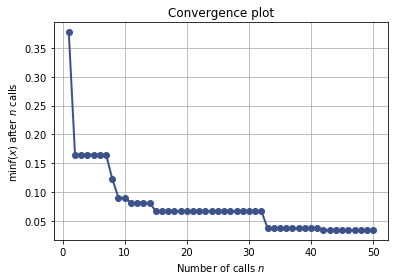

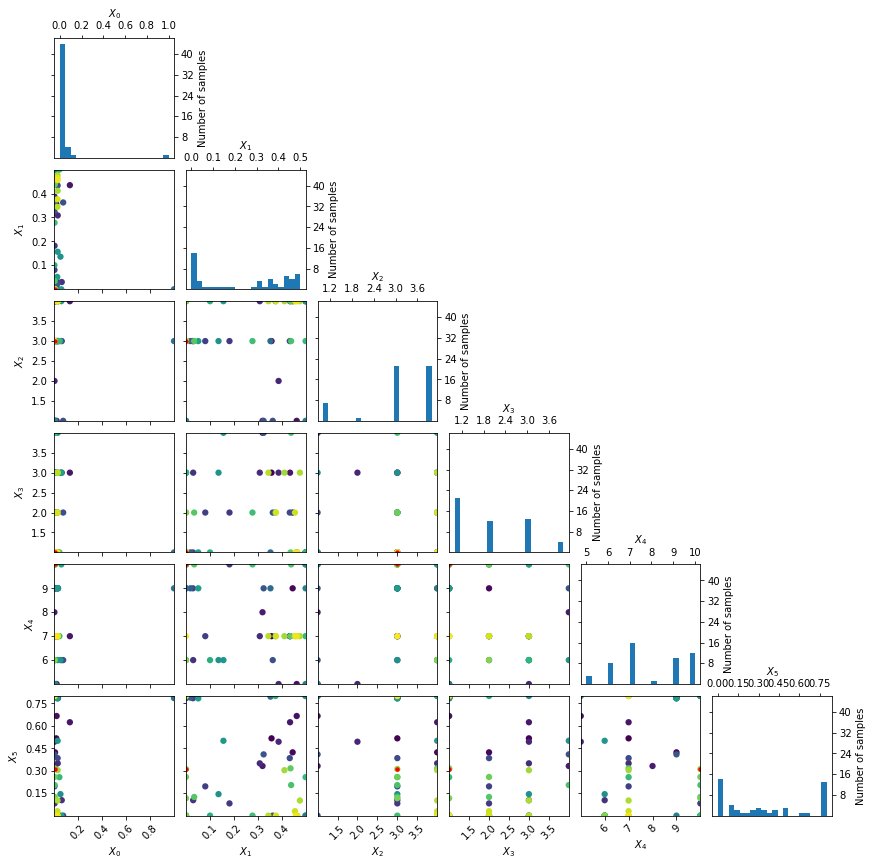

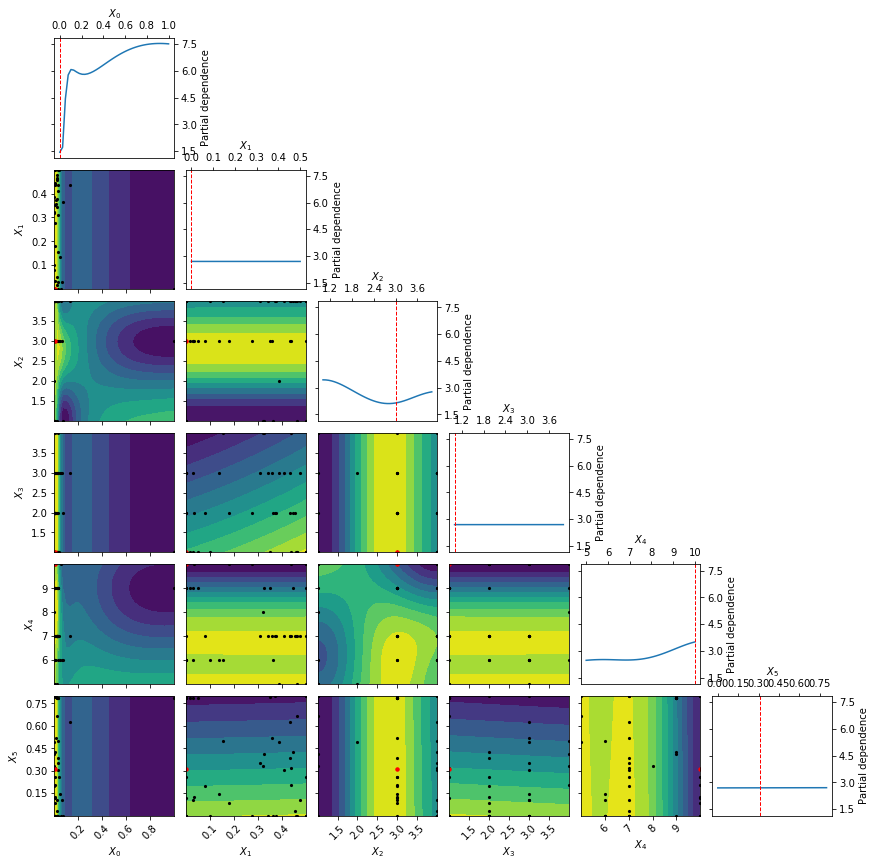

In [6]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

plot_convergence(res_gp);
plot_evaluations(res_gp);
plot_objective(res_gp);

In [10]:
# using best params
model = build_model(*res_gp.x)
model.fit(x_train, y_train, epochs=20, batch_size=1024)
model.evaluate(x_test, y_test, batch_size=1024, verbose=0)

Epoch 1/20
60000/60000 [==============================] - 3s - loss: 1.9980 - acc: 0.7717     
Epoch 2/20
60000/60000 [==============================] - 1s - loss: 0.1339 - acc: 0.9579     
Epoch 3/20
60000/60000 [==============================] - 1s - loss: 0.0589 - acc: 0.9816     
Epoch 4/20
60000/60000 [==============================] - 1s - loss: 0.0416 - acc: 0.9874     
Epoch 5/20
60000/60000 [==============================] - 1s - loss: 0.0351 - acc: 0.9892     
Epoch 6/20
60000/60000 [==============================] - 1s - loss: 0.0296 - acc: 0.9907     
Epoch 7/20
60000/60000 [==============================] - 1s - loss: 0.0259 - acc: 0.9917     
Epoch 8/20
60000/60000 [==============================] - 1s - loss: 0.0204 - acc: 0.9936     
Epoch 9/20
60000/60000 [==============================] - 1s - loss: 0.0183 - acc: 0.9942     
Epoch 10/20
60000/60000 [==============================] - 1s - loss: 0.0163 - acc: 0.9948     
Epoch 11/20
60000/60000 [========================

[0.061239989328384398, 0.98880000495910647]